# DevOps Build Integration

In [2]:
# Import Libraries
import time
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet import MXNet
import json

# Global Variables
sagemaker_client = boto3.client('sagemaker')
iam_client = boto3.client('iam')
training_job = 'itsacat-train-v0-002'
build_id = '12345' # Build ID is generated from CodePipeline input artifacts
model_name = str(training_job.split('-')[0]+'-prod-'+''.join(training_job.split('-')[2:])+'-'+build_id)
training_job_info = sagemaker_client.describe_training_job(TrainingJobName=training_job)
training_job_name = str(training_job_info['HyperParameters']['sagemaker_job_name'].split('"')[1])

# Create IAM Role for SageMaker Session
role_response = iam_client.create_role(
    RoleName=model_name+'-Role',
    AssumeRolePolicyDocument='{ "Version": "2012-10-17", "Statement": [ { "Effect": "Allow", "Principal": { "Service": "sagemaker.amazonaws.com" }, "Action": "sts:AssumeRole" } ] }'
)
time.sleep(5)
print("Created IAM Role for SageMaker Session.")

# Attach Managed Role Policy
iam_client.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonSageMakerFullAccess',
    RoleName=role_response['Role']['RoleName']
)
print("Attached Managed Policy to SageMaker Session.")
time.sleep(5)

# Create a model using the Session API
# by attaching to the training job
print("Attaching estimator to training job: {}".format(training_job_name))
sagemaker_role = role_response['Role']['Arn']
estimator = MXNet.attach(training_job_name)
session = sagemaker.Session()
time.sleep(5)
model = estimator.create_model()
container_def = model.prepare_container_def(instance_type='ml.m4.xlarge')
session.create_model(model_name, sagemaker_role, container_def)

# Create endpoint config using the Session API
endpoint_config_name = session.create_endpoint_config(
    name=model_name,
    model_name=model_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge'
)

# Create endpoint using the boto3 API
print("Creating Endpoint ...")
create_endpoint_response = sagemaker_client.create_endpoint(
    EndpointName=model_name,
    EndpointConfigName=endpoint_config_name
)

# Wait until the status has changed
sagemaker_client.get_waiter('endpoint_in_service').wait(EndpointName=model_name)

# Print the final status of the endpoint
endpoint_response = sagemaker_client.describe_endpoint(EndpointName=model_name)
status = endpoint_response['EndpointStatus']
print('Endpoint status: {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')
else:
    endpoint_file={
        "endpoint": model_name
    }
    with open('endpoint.json', 'w') as f:
        json.dump(endpoint_file, f)

---
# DevOps Prod Integration

In [12]:
# Function to process image url
import urllib3
import numpy as np
import matplotlib.pyplot as plt
from cStringIO import StringIO
import json
from PIL import Image
from skimage import transform

def process_url(url):
    """
    Retrieves image from a URL and converts the image
    to a Numpy Array as the Payload for the SageMaker
    hosted endpoint.
    
    Arguments:
    url -- Full URL of the image
    
    Returns:
    payload -- Preprocessed image as a numpy array and returns a list
    """
    http = urllib3.PoolManager()
    req = http.request('GET', url)
    image = np.array(Image.open(StringIO(req.data)))
    result = transform.resize(image, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
    return image, result.tolist()

/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Prediction = "non-cat" picture.


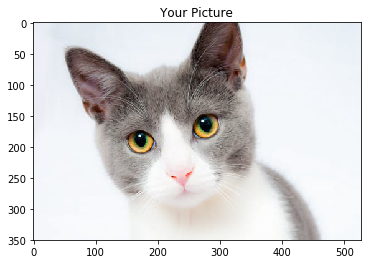

In [13]:
# Create a runtime object that can be used to
# invoke the endpoint
runtime = boto3.client(service_name='runtime.sagemaker')

# Create the payload for the endpoint
url = 'https://images.pexels.com/photos/104827/cat-pet-animal-domestic-104827.jpeg?auto=compress&cs=tinysrgb&h=350'
#url = 'https://www.housingwire.com/ext/resources/images/editorial/A-New-Big-Images/states/New-York-City.jpg?1453402066'
#url = 'http://i0.kym-cdn.com/entries/icons/facebook/000/011/365/GRUMPYCAT.jpg'
#url = 'http://1.bp.blogspot.com/-NlbULNGkGoI/U0v-v4EtjTI/AAAAAAAAAZ0/EZBRyG3I2DI/s1600/gargoyle-gargoile-demon-notre-dame-paris.jpg'
image, payload = process_url(url)

# Invoke the SageMaker endpoint
response = runtime.invoke_endpoint(
    EndpointName=model_name,
    ContentType='application/json',
    Body=json.dumps(payload)
)

# Format the prediction
prediction = json.loads(response['Body'].read().decode('utf-8'))

# Display results
classes = ['non-cat', 'cat']
print('Prediction = \"'+classes[int(prediction)]+'\" picture.')
plt.title("Your Picture")
plt.imshow(image);

__Test Prediciton App__

/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Prediction = "non-cat" picture.


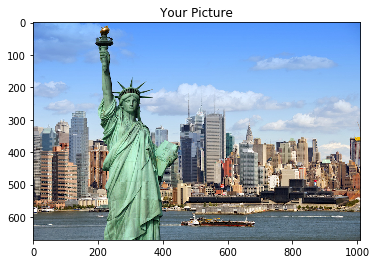

In [17]:
# Function to process image url
import urllib3
import numpy as np
import matplotlib.pyplot as plt
from cStringIO import StringIO
from PIL import Image
from skimage import transform
import boto3

def process_url(url):
    """
    Retrieves image from a URL and converts the image
    to a Numpy Array as the Payload for the SageMaker
    hosted endpoint.
    
    Arguments:
    url -- Full URL of the image
    
    Returns:
    payload -- Preprocessed image as a numpy array and returns a list
    """
    http = urllib3.PoolManager()
    req = http.request('GET', url)
    image = np.array(Image.open(StringIO(req.data)))
    result = transform.resize(image, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
    return image, result.tolist()

# Create the payload for the endpoint
sagemaker_client = boto3.client('sagemaker')
#training_job = 'itsacat-train-v0-002'
build_id = '12345' # Build ID is generated from CodePipeline input artifacts
model_name = str(training_job.split('-')[0]+'-prod-'+''.join(training_job.split('-')[2:])+'-'+build_id)
training_job_info = sagemaker_client.describe_training_job(TrainingJobName=training_job)
runtime = boto3.client(service_name='runtime.sagemaker')
url = 'https://www.housingwire.com/ext/resources/images/editorial/A-New-Big-Images/states/New-York-City.jpg?1453402066'
image, payload = process_url(url)

# Invoke the SageMaker endpoint
response = runtime.invoke_endpoint(
    EndpointName=model_name,
    ContentType='application/json',
    Body=json.dumps(payload)
)

# Format the prediction
classes = ['non-cat', 'cat']
prediction = classes[int(json.loads(response['Body'].read().decode('utf-8')))]

# Display results
print('Prediction = \"'+prediction+'\" picture.')
plt.title("Your Picture")
plt.imshow(image);